In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ex_filepath = 'DATA/generation_monthly.xlsx'
excel_data = pd.read_excel(ex_filepath,sheet_name = None, 
                            names = ["YEAR", "MONTH", "STATE", "TYPE OF PRODUCER", "ENERGY SOURCE", "GENERATION (Megawatthours)"])
raw_df = pd.concat(excel_data.values(), keys=excel_data.keys(), ignore_index=True)

In [3]:
raw_df = pd.concat(excel_data.values(), keys=excel_data.keys(), ignore_index=True)
raw_df.shape


(530838, 6)

When we got the data from the excel file it grabbed rows above the headers. We can find all values in the 'YEAR' column and remove them from the dataframe. We can also remove rows that have values that are NaN. We can also check the integrity of the data by looking for duplicate rows. 

In [12]:
invalid_rows = raw_df[raw_df['YEAR'].str.isnumeric() == False]
df = raw_df.drop(invalid_rows.index).dropna()
df.duplicated().sum()



0

To ensure we didn't have change our data too much we check the shape of the dataframe before and after.

In [17]:
print("Shape of raw_df:")
print(raw_df.shape)

print("\nShape of df:")
print(df.shape)

removed_rows = raw_df.shape[0] - df.shape[0]
print(f'We removed {removed_rows} row(s).')

Shape of raw_df:
(530838, 6)

Shape of df:
(530790, 6)
We removed 48 row(s).


We can change the date types to make our data easier to work with. Then check what they are after we have changed them.

In [130]:
df = df.infer_objects()
df.dtypes


STATE                object
TYPE OF PRODUCER     object
ENERGY SOURCE        object
Generation (TWh)    float64
dtype: object

We want to take the year and month columns and convert them into a date colum we can use to index the dataframe. We dont have a day of the month so we just use a constant value of 1. We can not get rid of the year and month columns to clean up the dataframe. 

In [18]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(day=1),errors='coerce')
df.set_index('DATE', inplace=True)
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)


In [19]:
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549
2001-01-01,AK,Total Electric Power Industry,Wind,87
...,...,...,...,...
2023-09-01,WY,"Electric Generators, Electric Utilities",Coal,2635451
2023-09-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,39490
2023-09-01,WY,"Electric Generators, Electric Utilities",Natural Gas,95639


Converting the 'STATE' column to uppercase ensures a consistent and standardized representation of state names.

In [54]:
df['STATE'] = df['STATE'].str.upper()

To better understand our data we can get all they types of producers and the types of energy sources by using the .unique() method. This will also help us validate that we cleaned the data correctly. 

In [55]:
types_producer = df['TYPE OF PRODUCER'].unique()
types_producer

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Independent Power Producers'], dtype=object)

We can see there are really three categories in the producer columns. 
- Electric Generators
- Combined Heat and Power
- Total Electric Power Industry

Each have a subcategory too.

We can do the same for the Energy Source column

In [56]:
df['ENERGY SOURCE'].unique()
#COULD BE A PROBELM LOOKS LIKE THE HEADER IS IN THE DATA TOO.

array(['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional',
       'Wind', 'Total', 'Other Gases', 'Nuclear',
       'Wood and Wood Derived Fuels', 'Other Biomass', 'Other',
       'Solar Thermal and Photovoltaic', 'Pumped Storage', 'Geothermal'],
      dtype=object)

We can check on 'GENERATION (Megawatthours)' column and get some statistics that will describe our dataset. 

In [57]:
df['GENERATION (Megawatthours)'].describe()

count     530790
unique    274444
top            0
freq       36584
Name: GENERATION (Megawatthours), dtype: int64

We see that our standard diviation is very high and there is a large gap between the percentiles. This tell us that there is many outliers and values that are zero. Anohter thing to note is that the min value is a negitive number. This is data on the generaion of electiricy so we went to know why type of energy source is pulling power instead of producing it. 

We can plot a histogram to see how the data is distributed and get a visual representation. 

<Axes: >

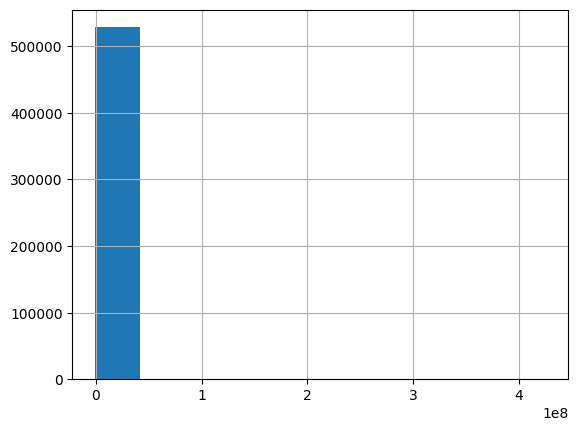

In [58]:
df['GENERATION (Megawatthours)'].hist()
#come back and add label and a title


The visual representation validates our observations from the describe() table, indicating a concentration of values around zero and notable outliers at the upper end. However, it's important to note that this graph represents a broad overview, encompassing diverse sources, states, and their totals spanning from 2001 to 2023. To narrow our focus and derive more targeted insights, we plan to apply filters, selecting specific subsets of data such as totals, specific sources, or particular states for further analysis.

In [59]:
df['TYPE OF PRODUCER'].value_counts()


TYPE OF PRODUCER
Total Electric Power Industry                       143564
Electric Generators, Electric Utilities             100222
Electric Generators, Independent Power Producers     95985
Combined Heat and Power, Industrial Power            82955
Combined Heat and Power, Commercial Power            58112
Combined Heat and Power, Electric Power              49952
Name: count, dtype: int64

The unit megawatthours is very small when dealing with net generation so we will reduce it to make it more manageable.

In [102]:
df["Generation (TWh)"] = df["GENERATION (Megawatthours)"]/1000000
df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)



In [131]:
df = df.infer_objects()
df.dtypes

STATE                object
TYPE OF PRODUCER     object
ENERGY SOURCE        object
Generation (TWh)    float64
dtype: object

# Start of analysis

### Understanding the Total electric power generation

We will start our analysis on the 'Total Electric Power Industry' to begin

In [60]:
total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']

In [66]:
df['STATE'].value_counts().head()

STATE
US-TOTAL    19506
CA          16495
MI          15090
PA          14070
NY          13791
Name: count, dtype: int64

In [67]:
US_total=total.loc[total['STATE']=='US-TOTAL']

In [68]:
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68707077
...,...,...,...,...
2023-09-01,US-TOTAL,Total Electric Power Industry,Petroleum,1620178
2023-09-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15529558
2023-09-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1255874


In [103]:
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
DATE,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177.287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18.111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42.388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,0.718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68.707077
...,...,...,...,...
2023-09-01,US-TOTAL,Total Electric Power Industry,Petroleum,1.620178
2023-09-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15.529558
2023-09-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1.255874


In [70]:
US_total['ENERGY SOURCE'].value_counts()


ENERGY SOURCE
Coal                              273
Petroleum                         273
Natural Gas                       273
Other Gases                       273
Nuclear                           273
Hydroelectric Conventional        273
Wind                              273
Solar Thermal and Photovoltaic    273
Wood and Wood Derived Fuels       273
Geothermal                        273
Other Biomass                     273
Pumped Storage                    273
Other                             273
Total                             273
Name: count, dtype: int64

In [71]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [72]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

In [73]:
US_source

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
1,2001-01-01,Geothermal,US-TOTAL,Total Electric Power Industry,1.229325
2,2001-01-01,Hydroelectric Conventional,US-TOTAL,Total Electric Power Industry,18.852048
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
...,...,...,...,...,...
3816,2023-09-01,Petroleum,US-TOTAL,Total Electric Power Industry,1.620178
3817,2023-09-01,Pumped Storage,US-TOTAL,Total Electric Power Industry,-0.543781
3818,2023-09-01,Solar Thermal and Photovoltaic,US-TOTAL,Total Electric Power Industry,15.529558
3820,2023-09-01,Wind,US-TOTAL,Total Electric Power Industry,28.193292


C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

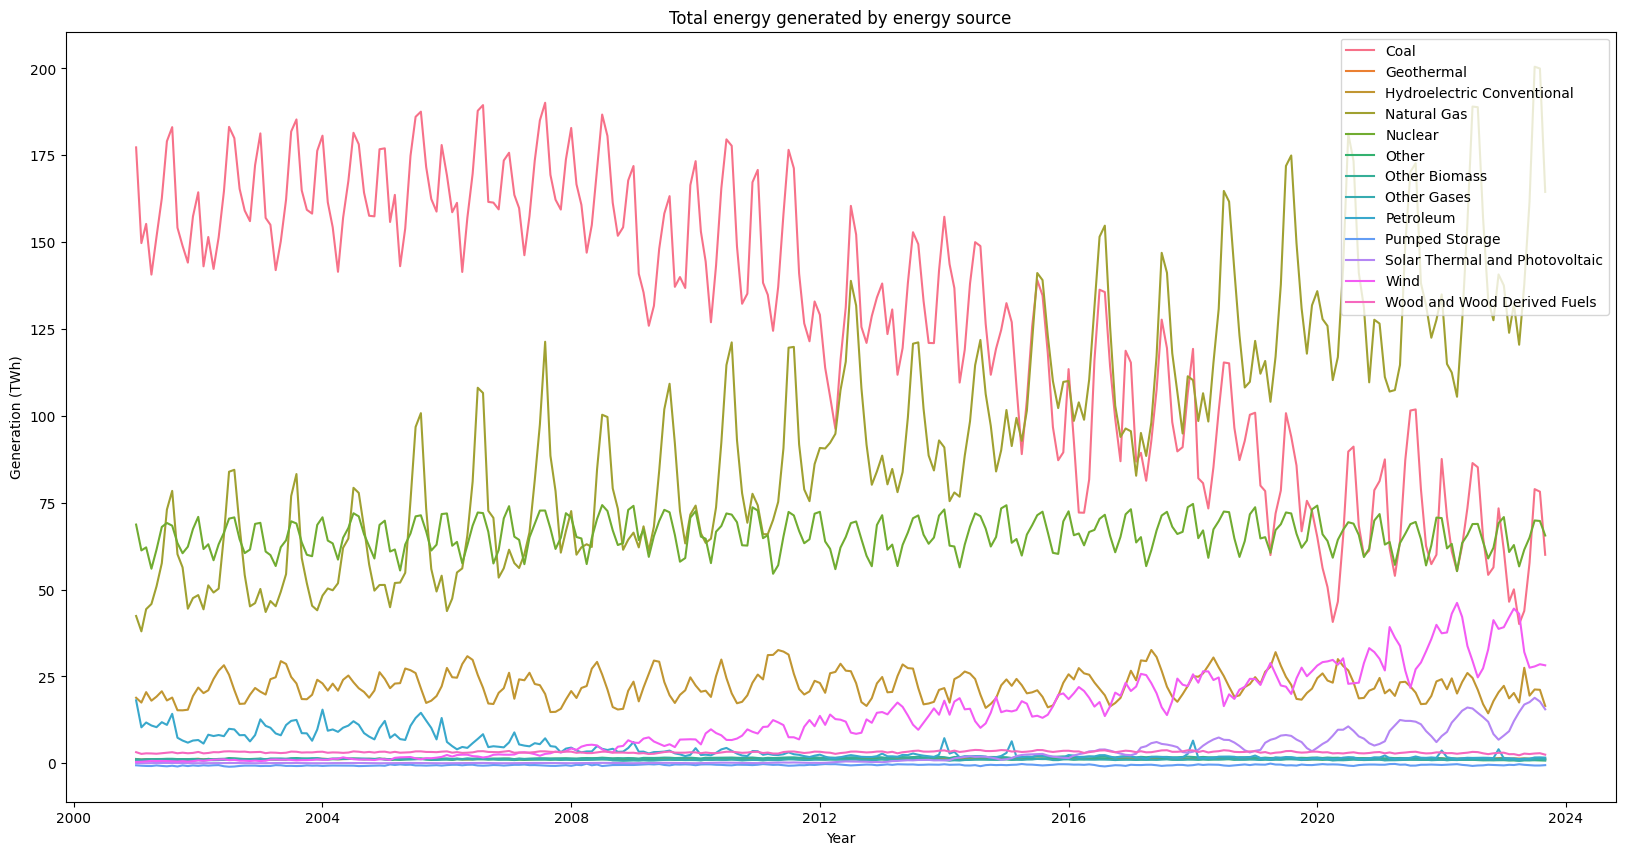

In [75]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source, x=US_source['DATE'] \
             ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [76]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [77]:
US_top3

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
14,2001-02-01,Coal,US-TOTAL,Total Electric Power Industry,149.735484
17,2001-02-01,Natural Gas,US-TOTAL,Total Electric Power Industry,37.966927
...,...,...,...,...,...
3797,2023-08-01,Natural Gas,US-TOTAL,Total Electric Power Industry,199.993042
3798,2023-08-01,Nuclear,US-TOTAL,Total Electric Power Industry,69.744023
3808,2023-09-01,Coal,US-TOTAL,Total Electric Power Industry,60.005676
3811,2023-09-01,Natural Gas,US-TOTAL,Total Electric Power Industry,164.466357


C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

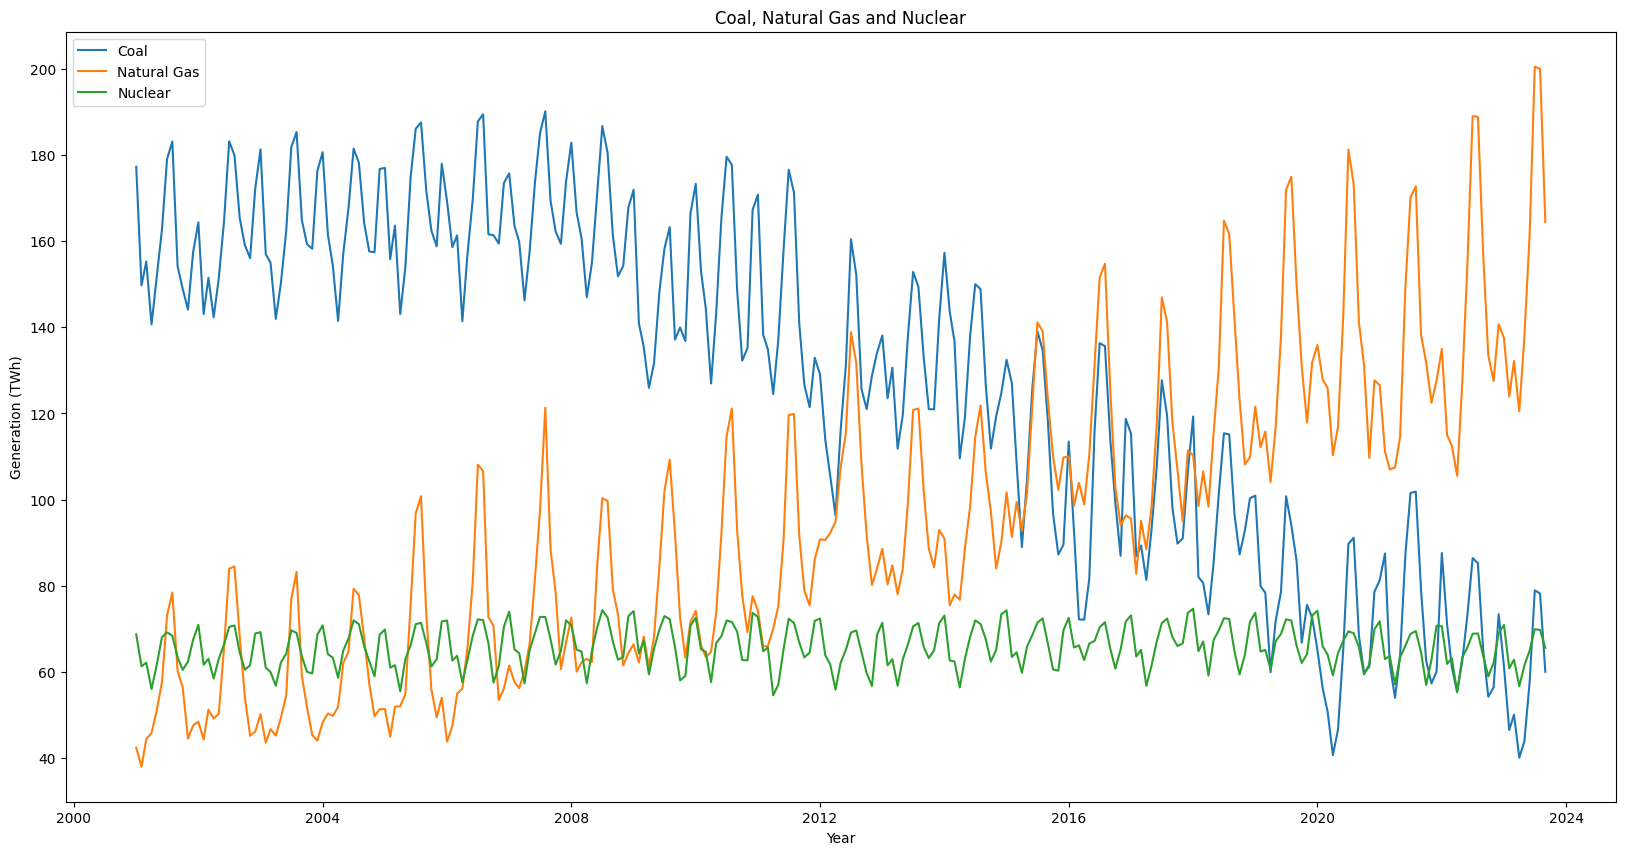

In [80]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['DATE'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best')

In [81]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

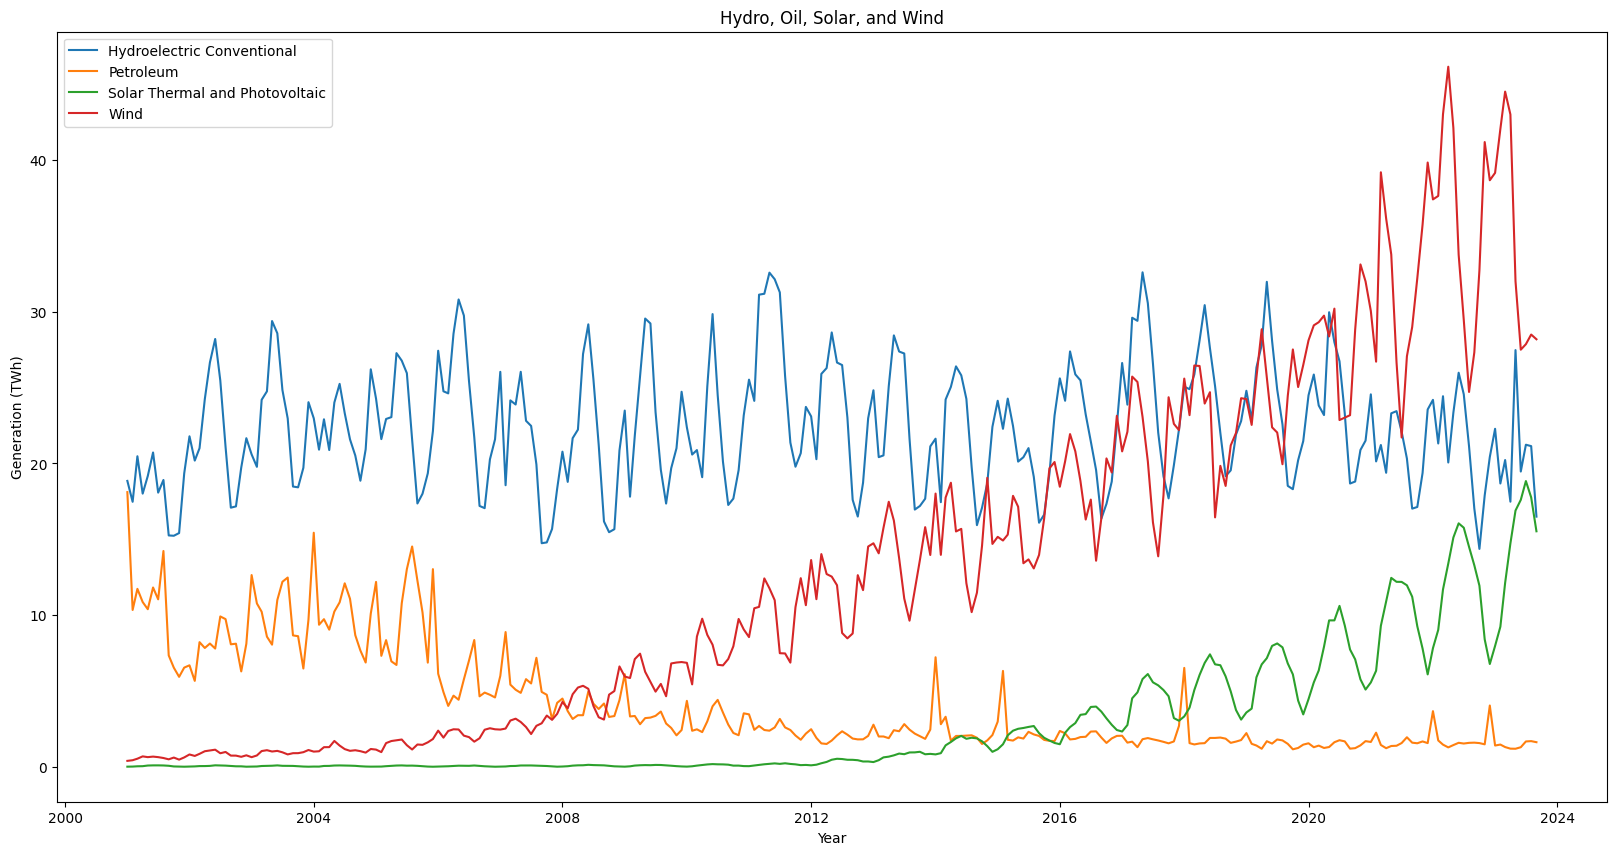

In [84]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['DATE'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Hydro, Oil, Solar, and Wind")
plt.xlabel("Year")
plt.legend(loc='best')

In [86]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

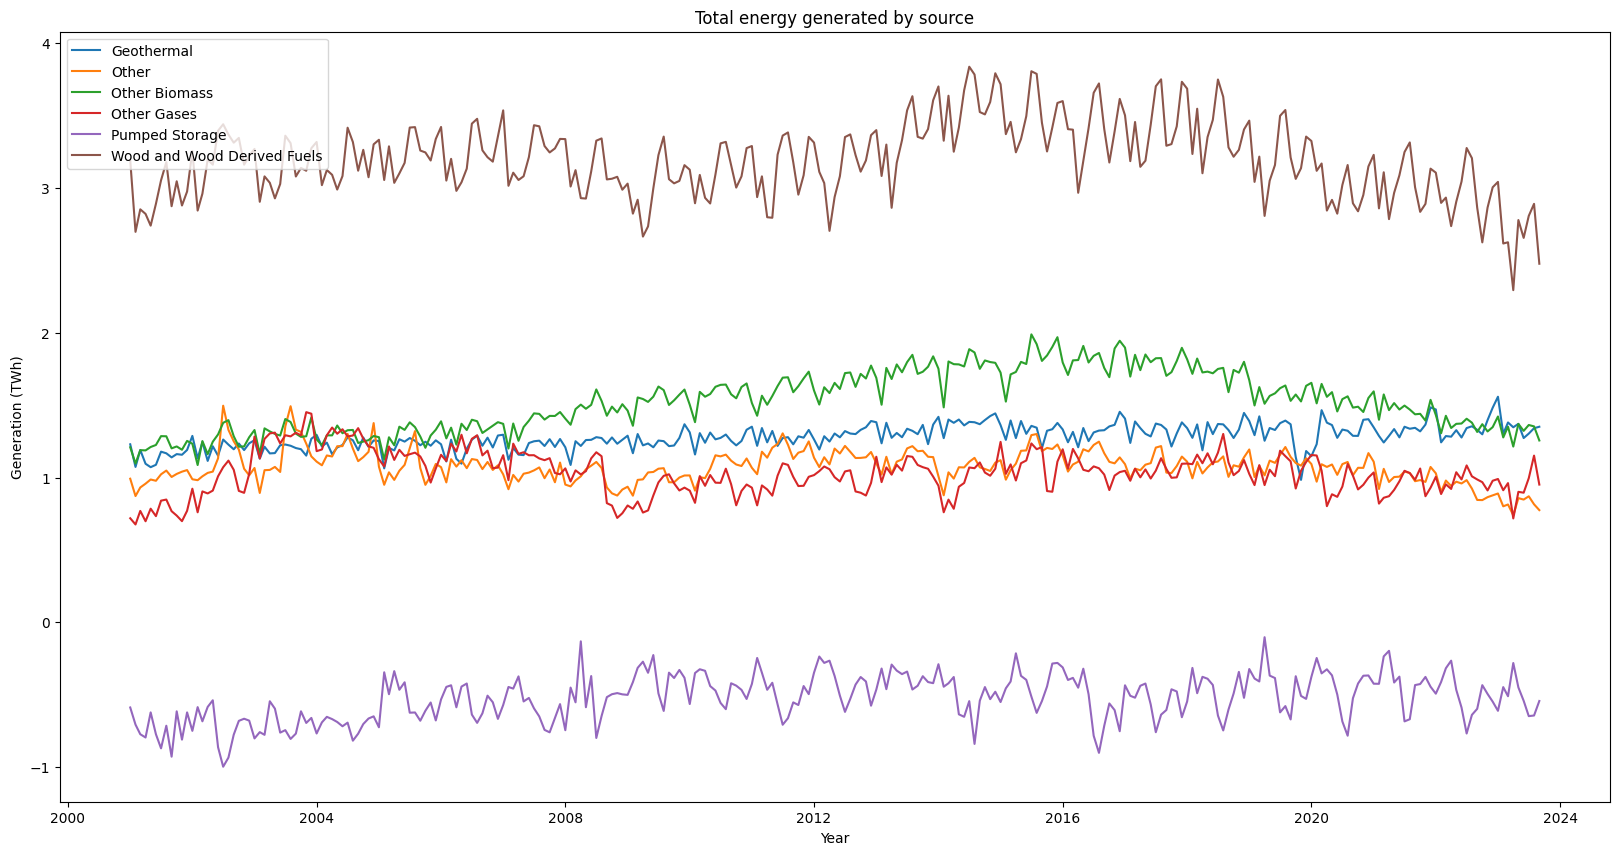

In [89]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['DATE'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source")
plt.xlabel("Year")
plt.legend(loc='upper left')

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

Text(0.5, 0, 'Year')

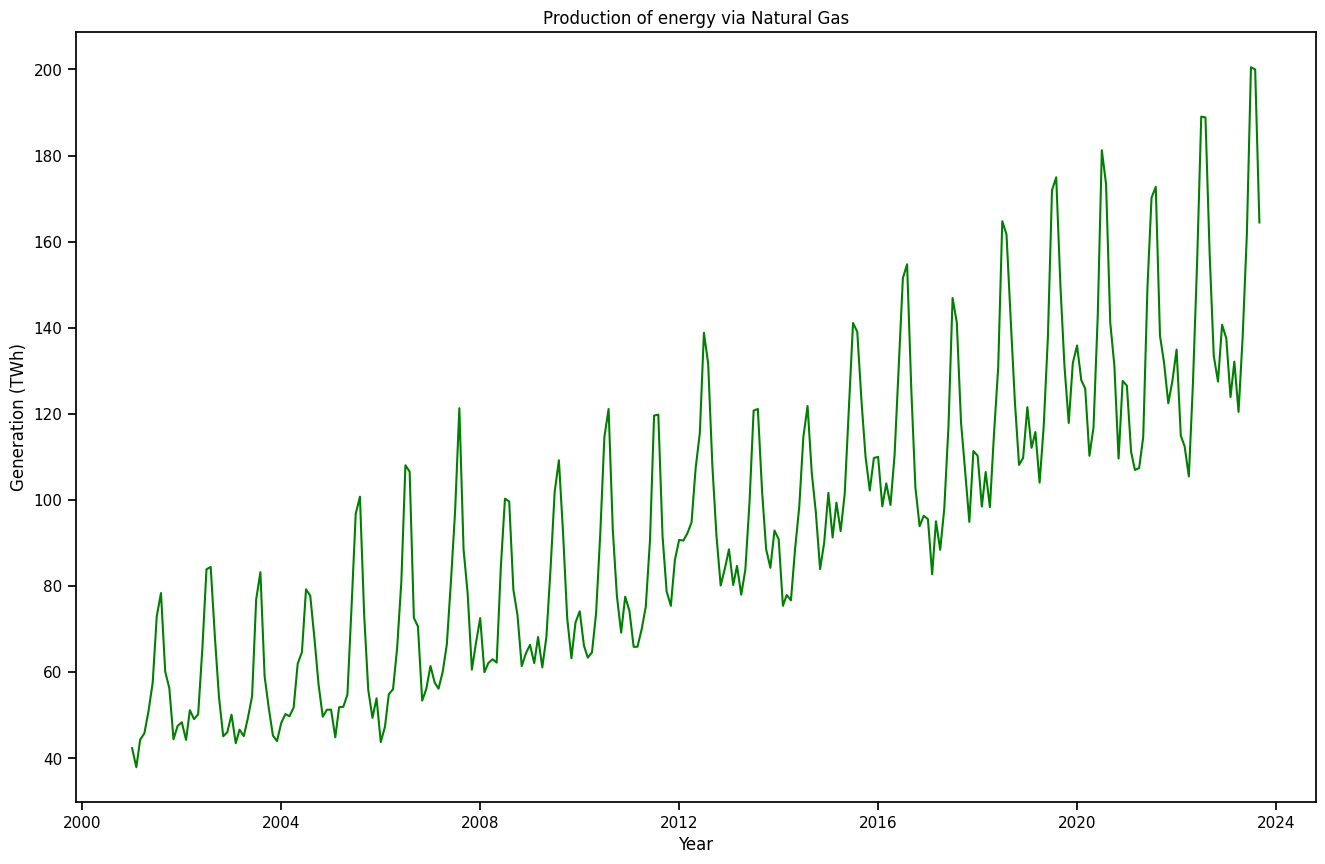

In [90]:
sns.set_context("notebook")
plt.figure(figsize=(16,10))
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green')
plt.title('Production of energy via Natural Gas')
plt.xlabel("Year")

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

Text(0.5, 0, 'Year')

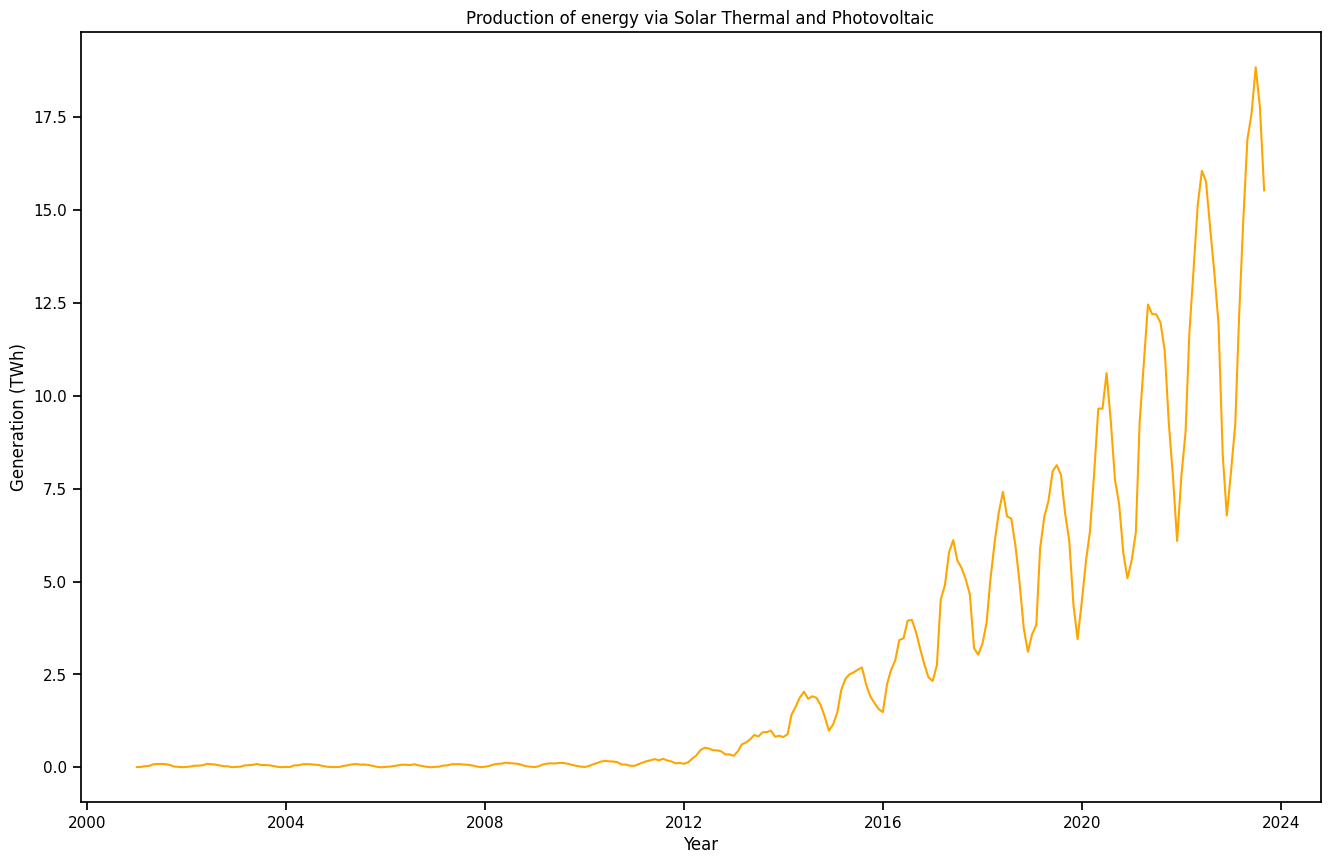

In [91]:
plt.figure(figsize=(16,10))
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange')
plt.title('Production of energy via Solar Thermal and Photovoltaic')
plt.xlabel("Year")

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

Text(0.5, 0, 'Year')

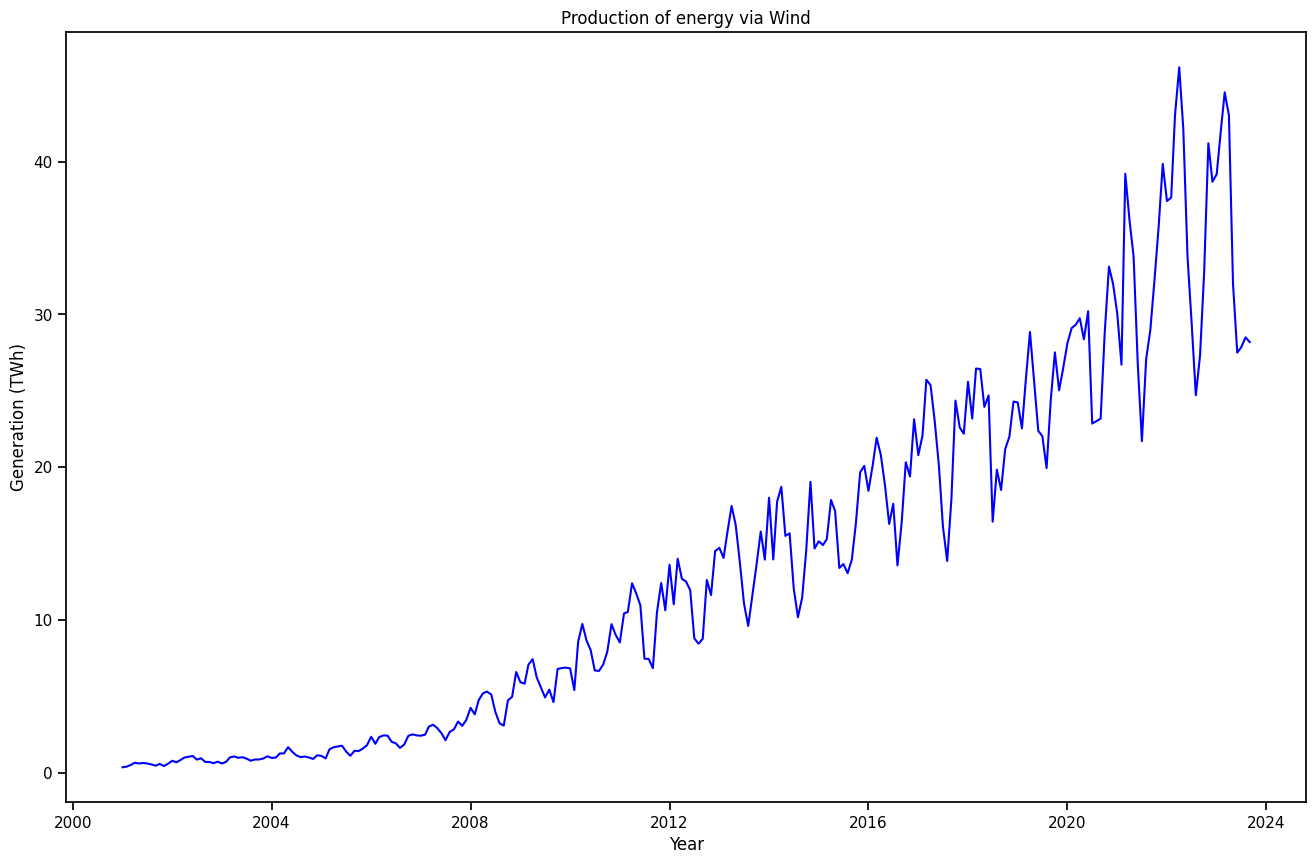

In [93]:
plt.figure(figsize=(16,10))
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)'], color='blue')
plt.title('Production of energy via Wind')
plt.xlabel("Year")

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

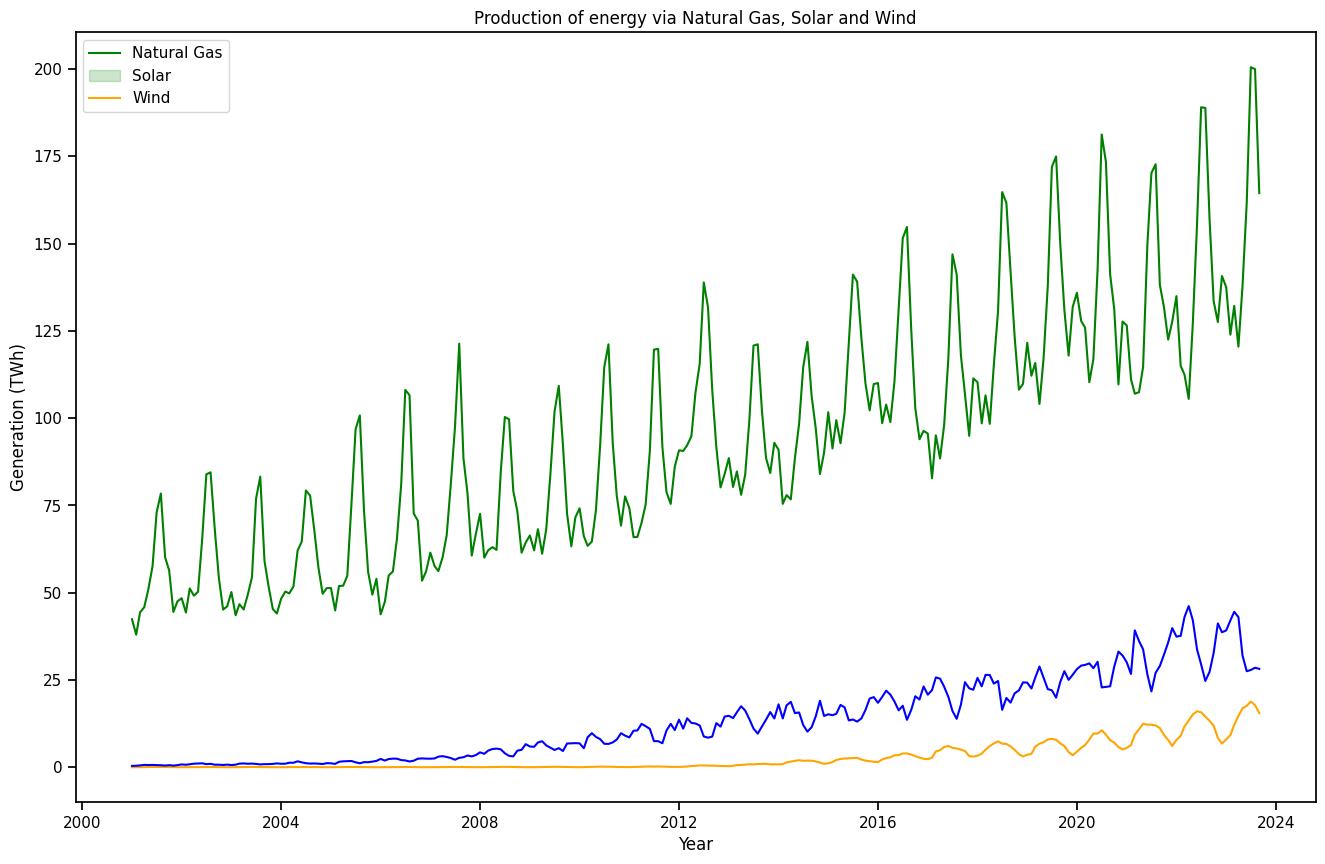

In [94]:
sns.set_context("notebook")
plt.figure(figsize=(16,10))
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green')
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange')
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)'], color='blue')
plt.title('Production of energy via Natural Gas, Solar and Wind')
plt.xlabel("Year")
plt.legend(['Natural Gas','Solar', 'Wind']);

Plot the derivitives of these to show growth

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


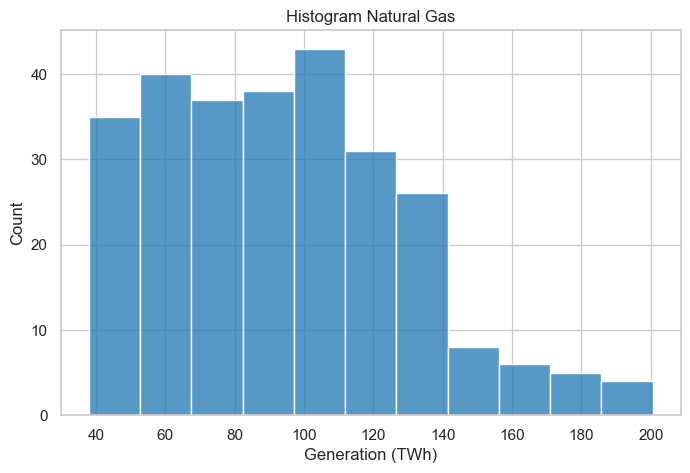

In [95]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.histplot(US_nat['Generation (TWh)'])
plt.title('Histogram Natural Gas');


C:\Users\nfs25\AppData\Local\Temp\ipykernel_27868\1051638199.py:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

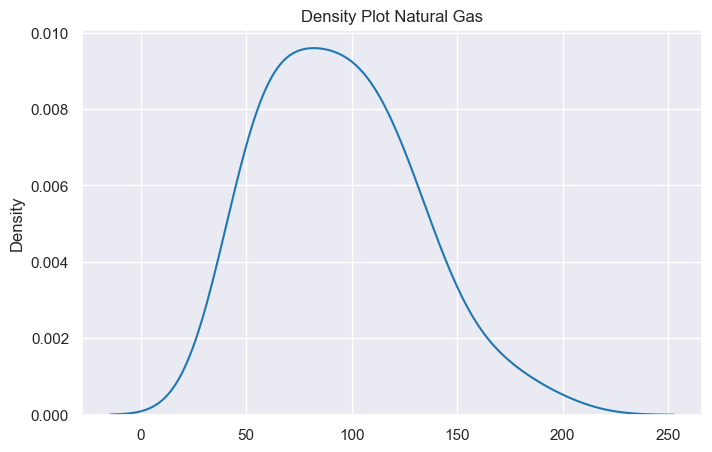

In [96]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Density Plot Natural Gas')
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);

do a 3 subplots for large med and small

Who create the most power? By state, by type of producer

In [97]:
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549
2001-01-01,AK,Total Electric Power Industry,Wind,87
...,...,...,...,...
2023-09-01,WY,"Electric Generators, Electric Utilities",Coal,2635451
2023-09-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,39490
2023-09-01,WY,"Electric Generators, Electric Utilities",Natural Gas,95639


In [110]:
state_total_month =df.groupby(by=[df.index,"STATE"]).sum().reset_index()

In [112]:
state_total_year =df.groupby(by=[df.index.year,"STATE"]).sum().reset_index()

In [159]:
total_alltime =df.groupby(by=["STATE"]).sum().reset_index().sort_values(by='Generation (TWh)')
state_total_alltime = total_alltime[total_alltime['STATE'] != 'US-TOTAL']


In [135]:
state_total_alltime.head(5)

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
43,TX,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,39579.555994
9,FL,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,20873.163033
38,PA,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,20144.804271
4,CA,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,18273.955042
14,IL,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,17366.465454


In [136]:
top_10_states = state_total_alltime.groupby('STATE')['Generation (TWh)'].sum().nlargest(10).index

In [151]:
state_total_month_top10=state_total_month[state_total_month['STATE'].isin(top_10_states)].sort_values(by='Generation (TWh)')

In [152]:
state_total_month_top10.head()

,DATE,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
9603,2016-05-01,OH,Total Electric Power IndustryTotal Electric Po...,TotalCoalHydroelectric ConventionalNatural Gas...,30.18338
5175,2009-04-01,NC,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,30.837467
157,2001-04-01,AL,Total Electric Power IndustryTotal Electric Po...,CoalPetroleumNatural GasOther GasesNuclearHydr...,30.857392
9291,2015-11-01,OH,Total Electric Power IndustryTotal Electric Po...,TotalCoalHydroelectric ConventionalNatural Gas...,31.620112
6735,2011-10-01,NC,"Combined Heat and Power, Commercial PowerCombi...",CoalHydroelectric ConventionalNatural GasPetro...,31.70538


C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

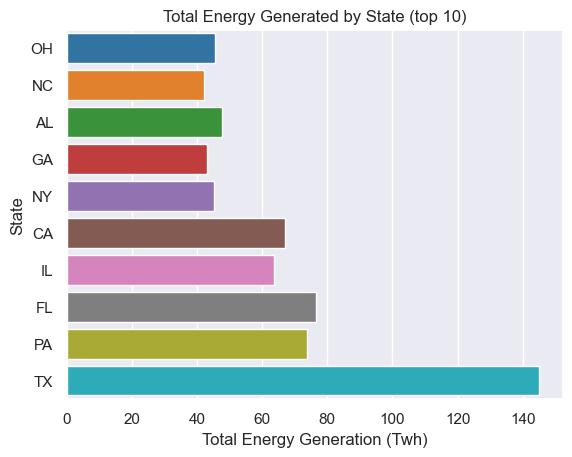

In [161]:
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_month_top10,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State (top 10)')

plt.show()

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

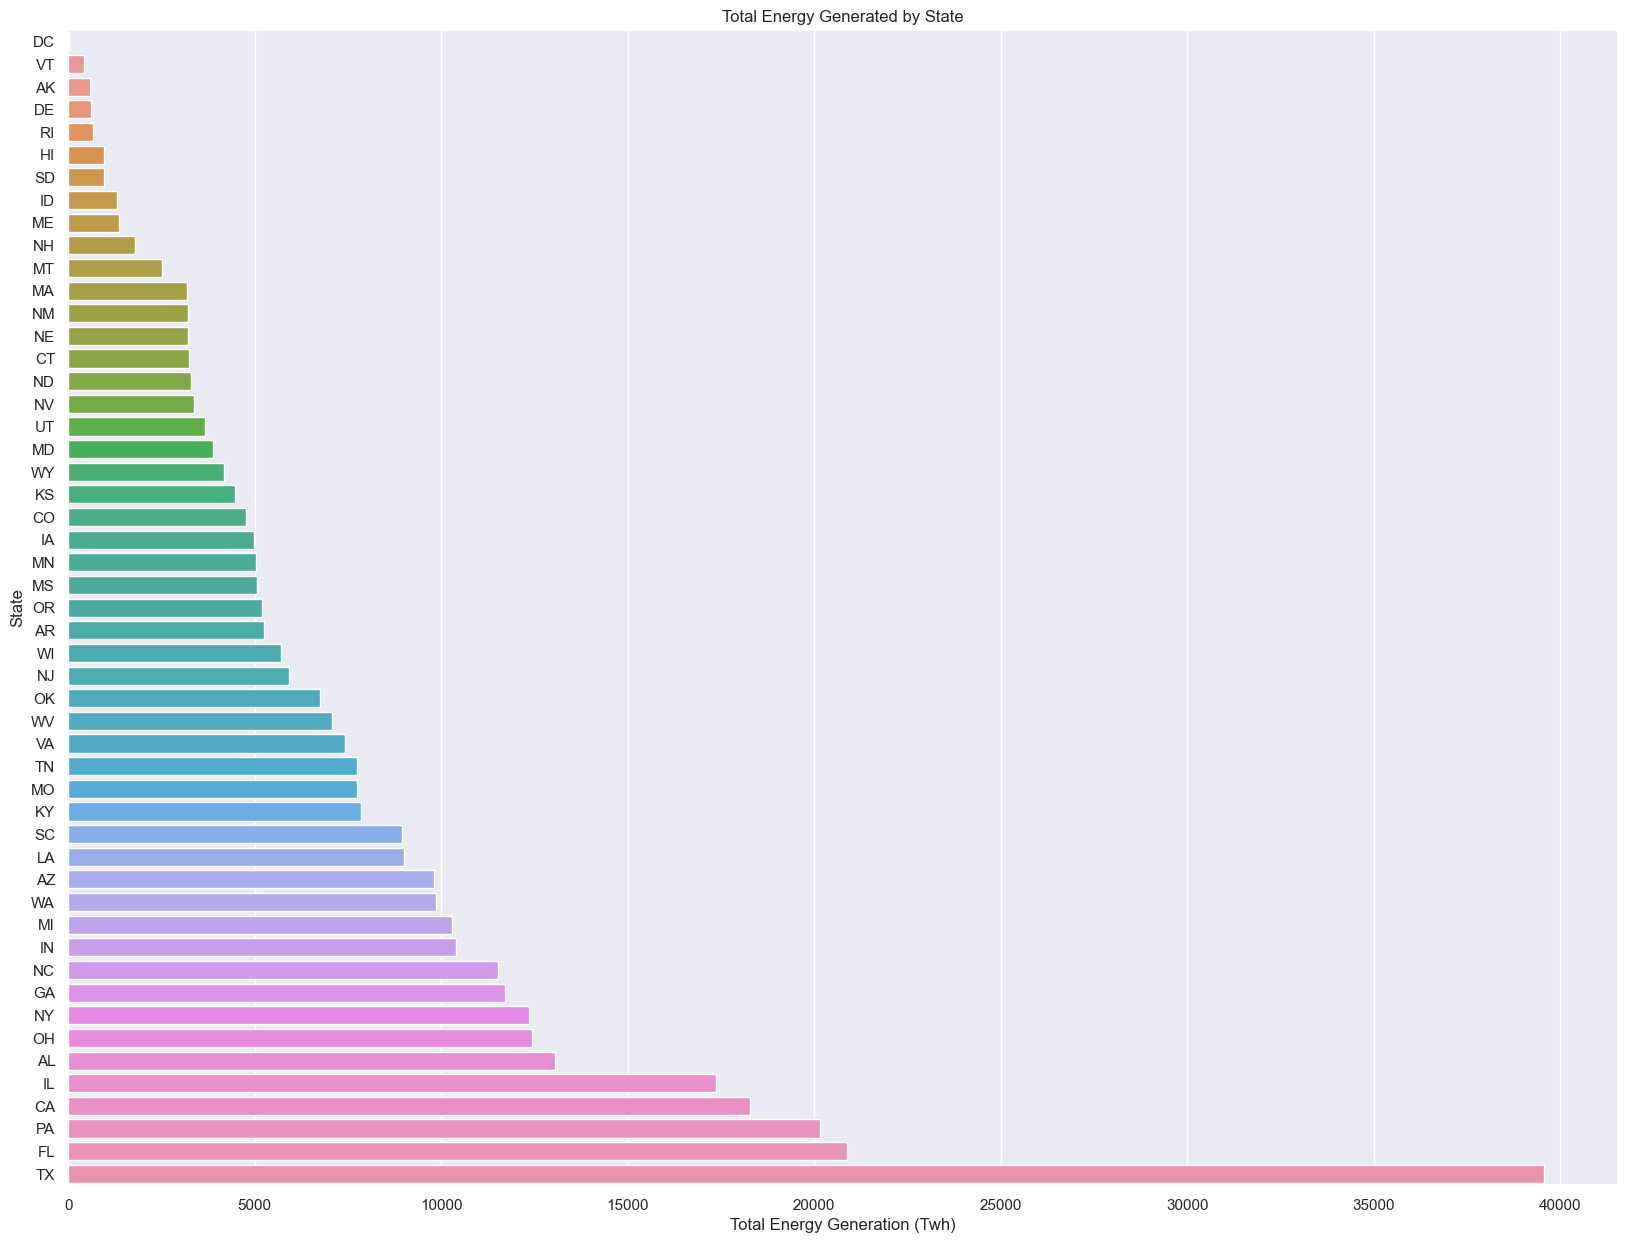

In [160]:
plt.figure(figsize=(20, 15))
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_alltime,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State')

plt.show()